## Correlation - examining overlap features
    BollBands_<period>..??? How to use??
    KAMA_<period>
    MesaAMA_f<fast period>_s<slow period>
    EMA_<period>
    SMA_<period>
    WghtdMA_<period>
    TripleMA_<period>
    DblExpMA_<period>
    InstTrendline
    Midpoint_<period>
    Midprice_<period>
    PSAR_<period>


In [1]:
%matplotlib inline

In [2]:
import json

from Code.lib.plot_utils import PlotUtility
from Code.lib.time_utils import TimeUtility
from Code.lib.retrieve_data import DataRetrieve, ComputeTarget
from Code.lib.candle_indicators import CandleIndicators
from Code.lib.transformers import Transformers
from Code.lib.ta_overlap_studies import TALibOverlapStudies
from Code.lib.model_utils import ModelUtility
from Code.lib.feature_generator import FeatureGenerator
from Code.utilities.stat_tests import stationarity_tests
from Code.lib.config import current_feature, feature_dict
from Code.models import models_utils

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
import pandas as pd
import numpy as np
import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pylab as plt
from pandas.tseries.offsets import BDay
import os.path
import pickle

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

### Load issue data and set date range
Pivot date is last date and time segments calculated by OOS months and IS-OOS ratio

In [5]:
plotIt = PlotUtility()
timeUtil = TimeUtility()
ct = ComputeTarget()
candle_ind = CandleIndicators()
dSet = DataRetrieve()
taLibOS = TALibOverlapStudies()
transf = Transformers()
modelUtil = ModelUtility()
featureGen = FeatureGenerator()
    
issue = "TLT"
# Set IS-OOS parameters
pivotDate = datetime.date(2018, 4, 2)
is_oos_ratio = 2
oos_months = 4
segments = 2

dataSet = dSet.read_issue_data(issue)

# get first data from loaded data instead of hard coding start date
dataSet = dSet.set_date_range(dataSet, "2014-09-26", pivotDate)

#set beLong level
beLongThreshold = 0.000
dataSet = ct.setTarget(dataSet, "Long", beLongThreshold)

Successfully retrieved data series for TLT


### Set features
Features should be normalized...

In [6]:
input_dict = {} # initialize
input_dict = {'f1': 
              {'fname' : 'exp_MA', 
               'params' : [4]
               },
              'f2': 
              {'fname' : 'simple_MA', 
               'params' : [4]
               },
              'f3': 
              {'fname' : 'weighted_MA', 
               'params' : [4]
               },
              'f4': 
              {'fname' : 'triple_EMA', 
               'params' : [4]
               },
              'f5': 
              {'fname' : 'triangMA', 
               'params' : [4]
               },
              'f6': 
              {'fname' : 'dblEMA', 
               'params' : [4]
               },
              'f7': 
              {'fname' : 'kaufman_AMA', 
               'params' : [4]
               },
              'f8': 
              {'fname' : 'delta_MESA_AMA', 
               'params' : [0.9, 0.1],
               'transform' : ['Normalized', 20]
               },
              'f9': 
              {'fname' : 'inst_Trendline', 
               'params' : []
               },
              'f10': 
              {'fname' : 'mid_point', 
               'params' : [4]
               },
              'f11': 
              {'fname' : 'mid_price', 
               'params' : [4]
               },
              'f12': 
              {'fname' : 'pSAR', 
               'params' : [4]
               }
             }
dataSet2 = featureGen.generate_features(dataSet, input_dict)

f1
Current feature:  EMA_4
transform:  None
f2
Current feature:  SMA_4
transform:  None
f3
Current feature:  WghtdMA_4
transform:  None
f4
Current feature:  TripleEMA_4
transform:  None
f5
Current feature:  TriangMA_4
transform:  None
f6
Current feature:  DblEMA_4
transform:  None
f7
Current feature:  KAMA_4
transform:  None
f8
Current feature:  DeltaMesaAMA_f0.9_s0.1
transform:  ['Normalized', 20]
f9
Current feature:  InstTrendline
transform:  None
f10
Current feature:  Midpoint_4
transform:  None
f11
Current feature:  Midprice_4
transform:  None
f12
Current feature:  PSAR_4
transform:  None


### Load processing dates for IS and OOS; set start date for model analysis

In [7]:
# set date splits
isOosDates = timeUtil.is_oos_data_split(issue, pivotDate, is_oos_ratio, oos_months, segments)
dataLoadStartDate = isOosDates[0]
is_start_date = isOosDates[1]
oos_start_date = isOosDates[2]
is_months = isOosDates[3]
is_end_date = isOosDates[4]
oos_end_date = isOosDates[5]

modelStartDate = is_start_date
modelEndDate = modelStartDate + relativedelta(months=is_months)
print("Issue: " + issue)
print("Start date: " + str(modelStartDate) + "  End date: " + str(modelEndDate))


predictor_vars = "Temp holding spot"

                    Segments:  2
                IS OOS Ratio:  2
                  OOS months:  4
                   IS Months:  8
              Months to load:  20
              Data Load Date:  2016-11-02
              IS Start  Date:  2016-12-02
              OOS Start Date:  2017-08-02
                  Pivot Date:  2018-04-02
Issue: TLT
Start date: 2016-12-02  End date: 2017-08-02


### Split data for analysis and make a copy for Expected Value calcs

In [8]:
mmData = dataSet[modelStartDate:modelEndDate].copy()
nrows = mmData.shape[0]

# EV related
evData = dataSet[modelStartDate:modelEndDate].copy()


### Select features to drop including OHL, gainAhead, symbol, Date, Close

In [9]:
col_vals = [k for k,v in feature_dict.items() if v == 'Drop']
to_drop = ['Open','High','Low', 'gainAhead', 'Symbol', 'Date', 'Close', 'beLong', 'Volume']
for x in to_drop:
    col_vals.append(x)
mmData = dSet.drop_columns(mmData, col_vals)

In [10]:
print(mmData.head())

                 EMA_4     SMA_4  WghtdMA_4  TripleEMA_4  TriangMA_4  \
2016-12-02  119.924336  120.1975    119.729   119.271929  119.960000   
2016-12-05  119.742602  119.5100    119.438   119.306389  119.395000   
2016-12-06  119.597561  119.2950    119.386   119.300582  119.375000   
2016-12-07  119.918537  119.7125    119.828   120.131765  119.616667   
2016-12-08  119.543122  119.5575    119.535   119.314407  119.668333   

              DblEMA_4      KAMA_4  DeltaMesaAMA_f0.9_s0.1_Normalized  \
2016-12-02  119.383932  121.464962                           0.780127   
2016-12-05  119.309319  121.090381                           0.734119   
2016-12-06  119.250567  120.971455                           0.750446   
2016-12-07  119.902926  120.804140                           0.886189   
2016-12-08  119.308507  120.727580                           0.875290   

            InstTrendline  Midpoint_4  Midprice_4    PSAR_4  
2016-12-02     124.826053     120.475   120.02000  121.4480  
2016

### Plot correlation matrix
Improve this to identify and drop features with corr value higher than 0.3
Look at other methods to identify features and their contribution

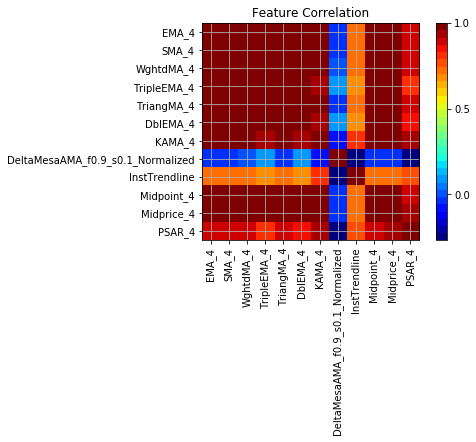

In [11]:
plotIt.correlation_matrix(mmData)

#### Examine and drop features with corr value > 0.85

In [12]:
# Create correlation matrix
corr_matrix = mmData.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
print(upper)

# Find index of feature columns with correlation greater than 0.85
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]
print("\n=====To Drop=====\n" + str(to_drop))

                                   EMA_4     SMA_4  WghtdMA_4  TripleEMA_4  \
EMA_4                                NaN  0.997349   0.998368     0.982065   
SMA_4                                NaN       NaN   0.996668     0.973024   
WghtdMA_4                            NaN       NaN        NaN     0.988170   
TripleEMA_4                          NaN       NaN        NaN          NaN   
TriangMA_4                           NaN       NaN        NaN          NaN   
DblEMA_4                             NaN       NaN        NaN          NaN   
KAMA_4                               NaN       NaN        NaN          NaN   
DeltaMesaAMA_f0.9_s0.1_Normalized    NaN       NaN        NaN          NaN   
InstTrendline                        NaN       NaN        NaN          NaN   
Midpoint_4                           NaN       NaN        NaN          NaN   
Midprice_4                           NaN       NaN        NaN          NaN   
PSAR_4                               NaN       NaN        NaN   